In [23]:
# TO BE DELETED

import sys
from typing import Iterable, Tuple

import numpy as np

sys.path.append("src")

import utils

In [2]:
data = utils.read_data("train")

In [3]:
min_, mean_, max_, var_, skw_, kurt_ = [np.empty((utils.meta.train_instances, utils.meta.n_columns)) for _ in range(6)]

for i_d, d in enumerate(data.values()):
    ts = d["ts"]
    min_[i_d] = ts.min(axis=0)
    mean_[i_d] = ts.mean(axis=0)
    max_[i_d] = ts.max(axis=0)
    var_[i_d] = ts.var(axis=0)
    skw_[i_d] = ts.skew(axis=0)
    kurt_[i_d] = ts.kurt(axis=0)

In [4]:
classes = [1 if d["class"] == "a" else 0 for d in data.values()]

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

X = np.hstack((min_, mean_, max_, var_, skw_, kurt_))
y = classes

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

model = LogisticRegression(max_iter=1000).fit(X_train, y_train)
print(model.score(X_test, y_test))
print(f1_score(y_test, model.predict(X_test)))

0.9419354838709677
0.9433962264150944


In [24]:
def idx_to_sensor_statistic(idx: int, moments: Iterable[str] = (
        "minimum", "mean", "maximum", "variance", "skewness", "kurtosis")) -> Tuple[str, str]:
    sensor_id = idx % utils.meta.n_columns
    sensor_name = utils.meta.column_names[sensor_id]
    moment_id = idx // utils.meta.n_columns
    moment_name = moments[moment_id]
    return sensor_name, moment_name

In [25]:
idcs_sorted = np.argsort(np.abs(model.coef_))
for i_c, idx in enumerate(idcs_sorted.T[::-1]):
    if i_c > 20:
        break
    sensor, moment = idx_to_sensor_statistic(int(idx))
    print(f"top: {i_c:4d}, coef: {float(model.coef_[0, idx]): 2.4f}, sensor: {sensor:>4}, stat: {moment}")

top:    0, coef:  0.2059, sensor:   F4, stat: variance
top:    1, coef: -0.1772, sensor:  AF1, stat: variance
top:    2, coef:  0.1724, sensor:  FC5, stat: variance
top:    3, coef:  0.1647, sensor:  FP2, stat: variance
top:    4, coef:  0.1637, sensor:   P8, stat: variance
top:    5, coef:  0.1564, sensor:  PO2, stat: variance
top:    6, coef:  0.1487, sensor:   F8, stat: variance
top:    7, coef: -0.1471, sensor:   C2, stat: maximum
top:    8, coef: -0.1447, sensor:  PO8, stat: variance
top:    9, coef: -0.1430, sensor:  AF2, stat: variance
top:   10, coef:  0.1410, sensor:   F8, stat: maximum
top:   11, coef:  0.1385, sensor:  AF7, stat: variance
top:   12, coef: -0.1354, sensor:  FPZ, stat: variance
top:   13, coef: -0.1318, sensor:   CZ, stat: maximum
top:   14, coef: -0.1317, sensor:   O2, stat: variance
top:   15, coef: -0.1304, sensor:  AFZ, stat: variance
top:   16, coef:  0.1293, sensor:  CP6, stat: variance
top:   17, coef: -0.1280, sensor:  FT8, stat: variance
top:   18, co

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

X = var_
y = classes

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

model = LogisticRegression(max_iter=int(1e5)).fit(X_train, y_train)
print(model.score(X_test, y_test))
print(f1_score(y_test, model.predict(X_test)))

0.9225806451612903
0.9240506329113924


In [45]:
from sklearn.feature_selection import SelectFromModel

f1_hist = []

for n_features in range(1, X.shape[1]):
    selector = SelectFromModel(estimator=LogisticRegression(max_iter=int(1e5)), threshold=0,
                               max_features=n_features).fit(X, y)
    indices = selector.get_support()
    indices = np.where(indices)[0]
    X_n_train, X_n_test = X_train[:, indices], X_test[:, indices]
    model = LogisticRegression(max_iter=int(1e5)).fit(X_n_train, y_train)
    f1_hist.append(f1_score(y_test, model.predict(X_n_test)))

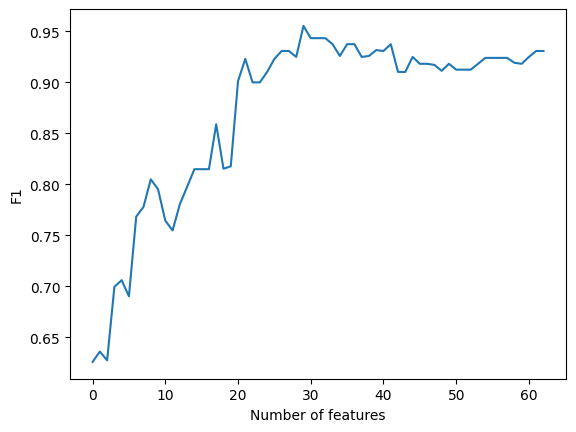

Number of features yielding solution of best quality (argmax): 29


In [48]:
from matplotlib import pyplot as plt

plt.plot(f1_hist)
plt.xlabel("Number of features")
plt.ylabel("F1")
plt.show()

print(f"Number of features yielding solution of best quality (argmax): {np.argmax(f1_hist)}")

In [53]:
selector = SelectFromModel(estimator=LogisticRegression(max_iter=int(1e5)), threshold=0,
                           max_features=np.argmax(f1_hist) + 1).fit(X, y)
indices = selector.get_support()
indices = np.where(indices)[0]
X_n_train, X_n_test = X_train[:, indices], X_test[:, indices]
model = LogisticRegression(max_iter=int(1e5)).fit(X_n_train, y_train)

print(f"accuracy: {model.score(X_n_test, y_test)}")
print(f"f1: {f1_score(y_test, model.predict(X_n_test))}\n===")

idcs_sorted = np.argsort(np.abs(model.coef_))
for i_c, idx in enumerate(idcs_sorted.T[::-1]):
    sensor, moment = idx_to_sensor_statistic(int(idx), moments=["variance"])
    print(f"top: {i_c:4d}, coef: {float(model.coef_[0, idx]): 2.4f}, sensor: {sensor:>4}, stat: {moment}")

accuracy: 0.9548387096774194
f1: 0.9554140127388535
===
top:    0, coef: -0.9789, sensor:   C3, stat: variance
top:    1, coef:  0.8989, sensor:  CP4, stat: variance
top:    2, coef: -0.8882, sensor:  AF8, stat: variance
top:    3, coef: -0.8131, sensor:   C2, stat: variance
top:    4, coef: -0.8049, sensor:   F7, stat: variance
top:    5, coef:  0.7357, sensor:   C4, stat: variance
top:    6, coef:  0.7249, sensor:   C6, stat: variance
top:    7, coef:  0.7135, sensor:  CP1, stat: variance
top:    8, coef: -0.7012, sensor:   F4, stat: variance
top:    9, coef:  0.6367, sensor:   F8, stat: variance
top:   10, coef:  0.5833, sensor:   C1, stat: variance
top:   11, coef: -0.5662, sensor:  AF2, stat: variance
top:   12, coef: -0.5347, sensor:   F1, stat: variance
top:   13, coef:  0.5064, sensor:  FC2, stat: variance
top:   14, coef:  0.3535, sensor:   CZ, stat: variance
top:   15, coef: -0.3440, sensor:   F5, stat: variance
top:   16, coef:  0.3345, sensor:  AFZ, stat: variance
top:   17